# Rolling Ratings

In [2]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

fig_DIR = "../figs/teams/"
box_DIR = "../data/box/"

In [3]:
def rolling_val(df, val):
    df["r" + val] = (
        df.apply(lambda x: x[val] * x["poss"], axis=1).cumsum() / df["tposs"]
    )
    return df

In [11]:
def get_rolling_ratings(season=2024, remove_games_start=0, remove_games_end=0):
    df1 = pd.read_parquet(box_DIR + f"NBA_Box_T_Adv_{season}.parquet")
    df1 = df1.rename(
        columns={
            "offensiveRating": "ORtg",
            "defensiveRating": "DRtg",
            "netRating": "NRtg",
            "possessions": "poss",
        }
    )
    cols = ["gameId", "teamId", "ORtg", "DRtg", "NRtg", "poss"]
    df1 = df1[cols]
    df1["Win"] = df1["NRtg"] > 0
    df1["Loss"] = df1["NRtg"] < 0
    df2 = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}.parquet")
    df2 = df2.rename(
        columns={
            "GAME_ID": "gameId",
            "TEAM_ID": "teamId",
            "TEAM_ABBREVIATION": "teamTricode",
            "GAME_DATE": "gameDate",
            "TEAM_NAME": "teamName",
        }
    )
    cols2 = ["gameId", "teamId", "teamTricode", "gameDate"]
    df2 = df2[cols2]
    df2["gameId"] = df2["gameId"].astype(int)
    # df33 = pd.read_csv(box_DIR + f"NBA_BoxScores_4Factor_{season}.csv")
    # df33 = df33.rename(columns={"effectiveFieldGoalPercentage":"eFG1","freeThrowAttemptRate":"FTA1","teamTurnoverPercentage":"TOV1","offensiveReboundPercentage":"OREB1","oppEffectiveFieldGoalPercentage":"eFG2","oppFreeThrowAttemptRate":"FTA2","oppTeamTurnoverPercentage":"TOV2","oppOffensiveReboundPercentage":"OREB2"})
    # cols3 = ["gameId","teamId","eFG1","FTA1","TOV1","OREB1","eFG2","FTA2","TOV2","OREB2"]
    # df33 = df33[cols3]
    # df32 = pd.merge(df2,df1,on=["gameId","teamId"])
    # df3 = pd.merge(df32,df33,on=["gameId","teamId"])
    df3 = pd.merge(df2, df1, on=["gameId", "teamId"])
    df3 = df3.rename(columns={"gameDate": "Date"})
    df3["Date"] = pd.to_datetime(df3["Date"], format="%Y-%m-%d")
    df_teams = pd.read_csv("../data/NBA_teams_colors_logos.csv")
    df_teams = df_teams.rename(columns={"nameTeam": "Team"})
    df3 = pd.merge(df3, df_teams)
    df4 = df3.sort_values(by=["teamTricode", "Date"]).reset_index(drop=True)
    df6 = df3.sort_values(by=["Date"]).reset_index(drop=True)
    teams = df6["teamTricode"].unique()

    dfa = []
    dfa2 = []
    for team in teams:
        df5 = df4[df4["teamTricode"] == team].reset_index(drop=True)
        df5["tposs"] = df5["poss"].cumsum()
        # vals = ["ORtg","DRtg","eFG1","FTA1","TOV1","OREB1","eFG2","FTA2","TOV2","OREB2"]
        vals = ["ORtg", "DRtg"]
        for val in vals:
            df5 = rolling_val(df5, val)
        df5["rNRtg"] = df5["rORtg"] - df5["rDRtg"]
        df5["Wins"] = df5["Win"].cumsum()
        df5["Losses"] = df5["Loss"].cumsum()
        df5["Games_Played"] = df5["Wins"] + df5["Losses"]
        df5["Win_Frac"] = df5["Wins"] / df5["Games_Played"]
        df5["Rem_Wins"] = df5["Wins"].iloc[-1] - df5["Wins"]
        df5["Rem_Losses"] = df5["Losses"].iloc[-1] - df5["Losses"]
        df5["Rem_Games"] = df5["Games_Played"].iloc[-1] - df5["Games_Played"]
        df5["Rem_Win_Frac"] = df5["Rem_Wins"] / df5["Rem_Games"]
        rvals = ["r" + val for val in vals]
        for val in rvals[2:]:
            df5[val] = df5[val].round(3)
        df5["rORtg"] = df5["rORtg"].round(2)
        df5["rDRtg"] = df5["rDRtg"].round(2)
        df5["rNRtg"] = df5["rNRtg"].round(2)
        df5["Win_Frac"] = df5["Win_Frac"].round(4)
        df5["Rem_Win_Frac"] = df5["Rem_Win_Frac"].round(4)
        df5["Win_Percent"] = 100 * df5["Win_Frac"]
        df5["Rem_Win_Percent"] = 100 * df5["Rem_Win_Frac"]
        df8 = df5.tail(1)
        if remove_games_start > 0:
            df5 = df5.iloc[remove_games_start:]
        if remove_games_end > 0:
            df5 = df5.iloc[:-remove_games_end]
        df5 = df5.reset_index(drop=True)
        dfa.append(df5)
        dfa2.append(df8)

    data = pd.concat(dfa)
    dataf = pd.concat(dfa2)
    data["teamDup"] = data["teamTricode"]
    
    dates = df4["Date"].unique()
    dfb = []
    for date in dates:
        df7 = df6[df6["Date"] <= date].reset_index(drop=True)
        df7["tposs"] = df7["poss"].cumsum()
        vals = ["ORtg", "DRtg"]
        for val in vals:
            df7 = rolling_val(df7, val)
        df7["rNRtg"] = df7["rORtg"] - df7["rDRtg"]
        df7["rORtg"] = df7["rORtg"].round(2)
        df7["rDRtg"] = df7["rDRtg"].round(2)
        df7["rNRtg"] = df7["rNRtg"].round(2)
        dfb.append(df7.tail(1))
    data_avg = pd.concat(dfb).reset_index(drop=True)
    data_avg["teamTricode"] = "avg"
    data_avg["teamDup"] = data_avg["teamTricode"]
    data_avg = data_avg.drop(columns=["teamTricode"])

    return data, dataf, data_avg, df1, df2, df3

In [20]:
season = "2024"
data, dataf, data_avg, df1, df2, df3 = get_rolling_ratings(season)
# Date = "2023-11-23"
# data = data[data["Date"] > Date]
# data_avg = data_avg[data_avg["Date"] > Date]
data1 = data.copy().drop(columns=["teamTricode"])
data_avg  = data.copy()
data_avg["teamTricode"] = "avg"
data_avg["teamDup"] = data_avg["teamTricode"]
data_avg = data_avg.drop(columns=["teamTricode"])

In [23]:
data_avg.sort_values("Date")

,gameId,teamId,Date,ORtg,DRtg,NRtg,poss,Win,Loss,Team,...,Losses,Games_Played,Win_Frac,Rem_Wins,Rem_Losses,Rem_Games,Rem_Win_Frac,Win_Percent,Rem_Win_Percent,teamDup
0,22400062,1610612750,2024-10-22,109.6,115.8,-6.2,94.0,False,True,Minnesota Timberwolves,...,1,1,0.0000,8,6,14,0.5714,0.00,57.14,avg
0,22400062,1610612747,2024-10-22,115.8,109.6,6.2,95.0,True,False,Los Angeles Lakers,...,0,1,1.0000,9,5,14,0.6429,100.00,64.29,avg
0,22400061,1610612752,2024-10-22,119.8,145.1,-25.3,91.0,False,True,New York Knicks,...,1,1,0.0000,8,6,14,0.5714,0.00,57.14,avg
0,22400061,1610612738,2024-10-22,145.1,119.8,25.3,91.0,True,False,Boston Celtics,...,0,1,1.0000,13,2,15,0.8667,100.00,86.67,avg
0,22400070,1610612763,2024-10-23,120.0,119.2,0.8,105.0,True,False,Memphis Grizzlies,...,0,1,1.0000,8,7,15,0.5333,100.00,53.33,avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,22400032,1610612740,2024-11-22,106.9,113.1,-6.2,101.0,False,True,New Orleans Pelicans,...,13,17,0.2353,0,0,0,NaN,23.53,NaN,avg
16,22400034,1610612746,2024-11-22,104.0,88.0,16.0,100.0,True,False,LA Clippers,...,6,17,0.6471,0,0,0,NaN,64.71,NaN,avg
15,22400029,1610612749,2024-11-22,122.9,110.4,12.5,105.0,True,False,Milwaukee Bucks,...,9,16,0.4375,0,0,0,NaN,43.75,NaN,avg
14,22400027,1610612755,2024-11-22,122.8,107.7,15.1,92.0,True,False,Philadelphia 76ers,...,12,15,0.2000,0,0,0,NaN,20.00,NaN,avg


In [ ]:
sdfsd

## OFF

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/ORtg_trends_league.png


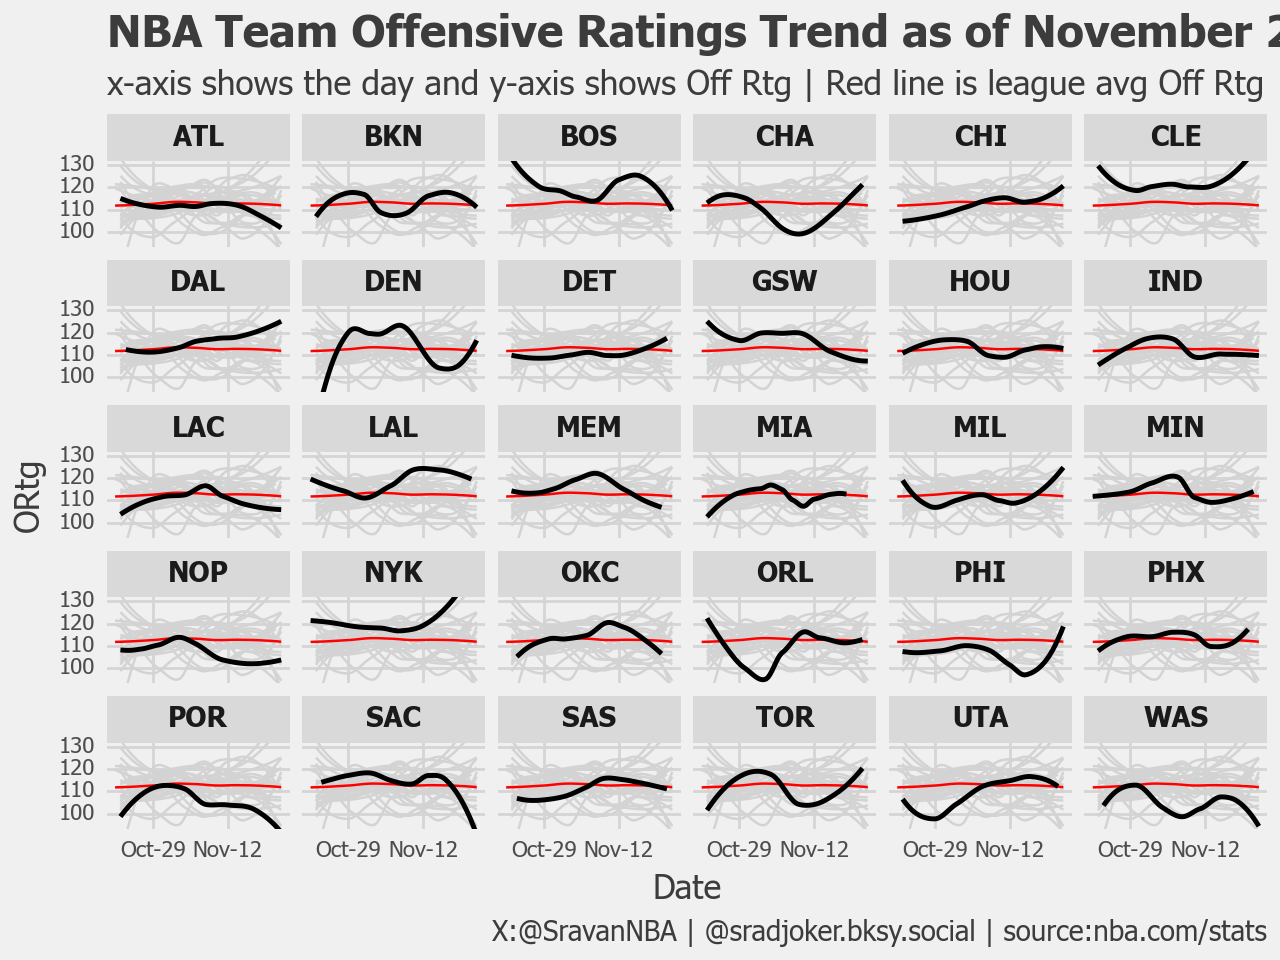

In [21]:
p = (
    ggplot(data)
    + geom_smooth(
        data=data1,
        mapping=aes(x="Date", y="ORtg", group="teamDup"),
        method="loess",
        color="lightgrey",
        se=False,
        size=0.5,
    )
    + geom_smooth(
        data=data_avg,
        mapping=aes(x="Date", y="ORtg", group="teamDup"),
        method="loess",
        color="red",
        se=False,
        size=0.5,
    )
    + geom_smooth(
        aes(x="Date", y="ORtg", group="teamTricode"),
        method="loess",
        color="Black",
        se=False,
        size=1,
    )
    + coord_cartesian(ylim=[95, 130])
    + scale_x_date(date_labels="%b-%d", date_breaks="2 week")
    + labs(
        title="NBA Team Offensive Ratings Trend as of " + datetime.today().strftime('%B %d, %Y'),
        subtitle="x-axis shows the day and y-axis shows Off Rtg | Red line is league avg Off Rtg",
        caption="X:@SravanNBA | @sradjoker.bsky.social | source:nba.com/stats",
    )
    + facet_wrap(facets="~ teamTricode")
    + theme_sra
)
p.save(fig_DIR + "ORtg_trends_league.png", width=10, height=10, dpi=300)
p.draw()

## DEF

In [24]:
p = (
    ggplot(data)
    + geom_smooth(
        data=data1,
        mapping=aes(x="Date", y="DRtg", group="teamDup"),
        method="loess",
        color="lightgrey",
        se=False,
        size=0.5,
    )
    + geom_smooth(
        data=data_avg,
        mapping=aes(x="Date", y="DRtg", group="teamDup"),
        method="loess",
        color="red",
        se=False,
        size=0.5,
    )
    + geom_smooth(
        aes(x="Date", y="DRtg", group="teamTricode"),
        method="loess",
        color="Black",
        se=False,
        size=1,
    )
    + coord_cartesian(ylim=[95, 130])
    + scale_x_date(date_labels="%b-%d", date_breaks="2 week")
    + labs(
        title="NBA Team Defensive Ratings Trend as of " + datetime.today().strftime('%B %d, %Y'),
        subtitle="x-axis shows the day and y-axis shows Def Rtg | Red line is league avg Def Rtg",
        caption="X:@SravanNBA | @sradjoker.bsky.social | source:nba.com/stats",
    )
    + facet_wrap(facets="~ teamTricode")
    + theme_sra
)
p.save(fig_DIR + "DRtg_trends_league.png", width=10, height=10, dpi=300)
p.draw()

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/DRtg_trends_league.png


## NET

In [25]:
p = (
    ggplot(data)
    + geom_smooth(
        data=data1,
        mapping=aes(x="Date", y="NRtg", group="teamDup"),
        method="loess",
        color="lightgrey",
        se=False,
        size=0.5,
    )
    + geom_smooth(
        aes(x="Date", y="NRtg", group="teamTricode"),
        method="loess",
        color="Black",
        se=False,
        size=1,
    )
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=0.5)
    # + ylim(-20, 20)
    # + scale_x_date(date_labels = "%b-%d",date_breaks = "2 week")
    # + ylim(-10, 10)
    + scale_x_date(date_labels="%b-%d", date_breaks="2 week")
    + labs(
        title="NBA Team Net Ratings as of " + datetime.today().strftime('%B %d, %Y'),
        subtitle="x-axis shows the day and y-axis shows Net Rating",
        caption="@SravanNBA | source:nba.com/stats",
    )
    + facet_wrap(facets="~ teamTricode")
    + theme_sra
)
p.save(fig_DIR + "NRtg_trends_league.png", width=10, height=10, dpi=300)
p.draw()

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 10 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/NRtg_trends_league.png


## Individual Team

In [ ]:
theme_idv = themes.theme_xkcd(base_size=11)  # , base_family="Tahoma")
theme_idv += theme(
    # plot_background = element_rect(fill = 'ghostwhite', color = "ghostwhite"),
    plot_title=element_text(face="bold", size=16),
    # strip_text = element_text(face = 'bold',size=10),
    # plot_caption = element_text(size=10),
    # plot_subtitle = element_text(size=12),
    # axis_text_x = element_text(size=8),
    # axis_text_y = element_text(size=8),
    # axis_title_x = element_text(size=12),
    # axis_title_y = element_text(size=12)
)

In [ ]:
team = "BOS"
for team in data["teamTricode"].unique():
#     if team not in ["SAS","BOS"]:
    data2 = data[data["teamTricode"] == team].reset_index(drop=True)
    var = "rNRtg"
    title = data2["Team"][0] + " Rolling Net Rating 2023-24"
    subtitle = "x-axis shows the day and y-axis shows Off Rtg | League Avg is red"

    p = (
        ggplot(data2)
        + geom_smooth(
            data=data1,
            mapping=aes(x="Date", y=var, group="teamDup"),
            method="loess",
            color="lightgrey",
            se=False,
            size=0.5,
        )
        + geom_smooth(
            aes(x="Date", y=var, group="teamTricode"),
            # method="loess",
            color="Black",
            se=False,
        )
        + geom_point(
            aes(x="Date", y=var, group="teamTricode"),
            color="Black",
        )
        # + geom_smooth(data= data_avg,mapping=aes(x="Date", y=var,group = "teamDup"),method="loess",color="red", se=False, size=0.5)
        + geom_hline(yintercept=0, linetype="dashed", color="red", size=0.5)
        # + ylim(-10, 10)
        + scale_x_date(date_labels="%b-%d", date_breaks="1 week")
        # + ylim(100, 130)
        + labs(
            title=title,
            subtitle=subtitle,
            caption="@SravanNBA | source:nba.com/stats",
        )
        + theme_idv
    )
    # p.save(fig_DIR + "Rolling_" + var + "_" + team + ".png", width=6, height=5, dpi=300)
    p.draw()